<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#data" data-toc-modified-id="data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data</a></span></li></ul></div>

# setup

In [1]:
import datetime
import gc
import json
import os
import sys
import pprint
import warnings
from io import BytesIO

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import folium
import geopandas as gpd
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4 as nc
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from folium.plugins import HeatMap
from IPython.display import display
from scipy.interpolate import griddata
from selenium import webdriver
from skimage.transform import resize
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
print(os.uname())
print()
print(sys.version)
print(sys.version_info)
print()
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

posix.uname_result(sysname='Linux', nodename='u22', release='6.2.0-36-generic', version='#37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2', machine='x86_64')

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

2.0.0+cu117
11.7
8500
NVIDIA GeForce GTX 1660 Ti
True


In [3]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [4]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
BRAZIL_EXTENT = [-74, -34, -34, 6]
SAO_PAULO_EXTENT = [-53, -44, -25, -20]

In [6]:
MAX_LAT = 32.99499999641088
MIN_LAT = -55.98500000358912
MAX_LON = -33.009801806103724
MIN_LON = -119.98980180610373

MAX_LAT = BRAZIL_EXTENT[3]
MIN_LAT = BRAZIL_EXTENT[2]
MAX_LON = BRAZIL_EXTENT[1]
MIN_LON = BRAZIL_EXTENT[0]

# data

## datasets intersection

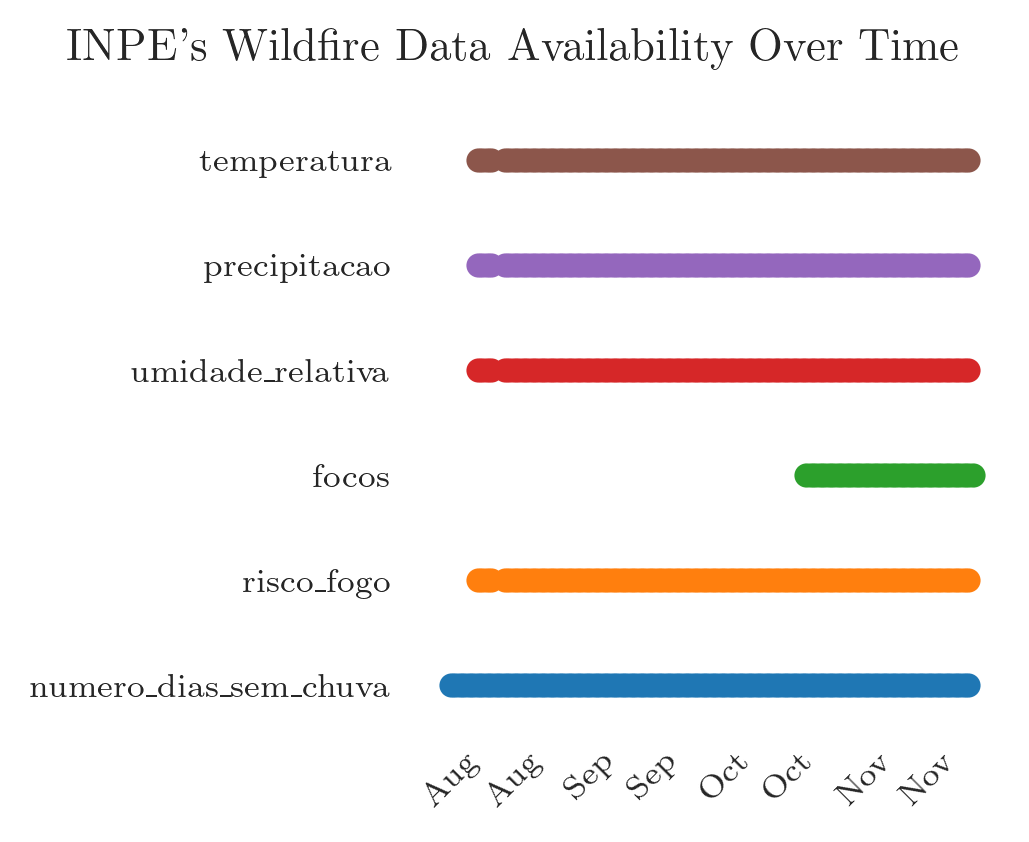

In [7]:
FILES = dict()

for root, dirs, files in os.walk("../data/01_raw/inpe_queimadas"):
    for file in files:
        if file.endswith(".nc"):
            file_name = os.path.join(root, file).split("/")[-1]
            folder_name = os.path.join(root, file).split("/")[-2]
            mmdd = file_name.split("2023")[-1].split(".nc")[0]
            yymmdd = datetime.datetime.strptime(f"2023{mmdd}", "%Y%m%d")
            if folder_name not in FILES:
                FILES[folder_name] = list()
                FILES[folder_name].append(yymmdd)
            else:
                FILES[folder_name].append(yymmdd)
        elif file.endswith(".csv"):
            file_name = os.path.join(root, file).split("/")[-1]
            folder_name = os.path.join(root, file).split("/")[-2]
            mmdd = file_name.split("2023")[-1].split(".csv")[0]
            yymmdd = datetime.datetime.strptime(f"2023{mmdd}", "%Y%m%d")
            if folder_name not in FILES:
                FILES[folder_name] = list()
                FILES[folder_name].append(yymmdd)
            else:
                FILES[folder_name].append(yymmdd)

fig, ax = plt.subplots()

for folder in FILES.keys():
    df = pd.DataFrame(FILES[folder], columns=["date"]).sort_values(by="date")
    df["date"] = pd.to_datetime(df["date"])
    ax.plot_date(x=df["date"], y=[folder] * len(df), fmt="o", label=folder)
    
    # datetime labels with month names
    ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%b'))
    plt.xticks(rotation=45)
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.grid(False)
    plt.suptitle("INPE's Wildfire Data Availability Over Time")
    plt.tight_layout()
    plt.savefig(f"../data/08_reporting/{experiment_name}/data_availability.png", dpi=300)

In [8]:
TENSOR = torch.load(f"../data/02_intermediate/wildfire_spread/wildfire_spread_tensor.pt")

In [9]:
LABELS = {
    0 : "Wildfire",
    1 : "Days Without Rain",
    2 : "Precipitation",
    3 : "Temperature",
    4 : "Relative Humidity",
    5 : "Fire Risk",
}

for _t, _timestamp in enumerate(TENSOR):
    for _index, _layer in enumerate(_timestamp):
        fig = plt.figure(figsize=(5, 5))
        ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
        ax.set_extent([MIN_LON, MAX_LON, MIN_LAT, MAX_LAT], crs=ccrs.PlateCarree())

        ax.imshow(
            _layer,
            origin="upper",
            extent=[MIN_LON, MAX_LON, MIN_LAT, MAX_LAT],
            transform=ccrs.PlateCarree(),
            cmap="gray"
        )
        
        plt.title(LABELS[_index])
        plt.tight_layout()
        plt.savefig(f"../data/08_reporting/wildfire_spread/{LABELS[_index].replace(' ', '-')}_{str(_t).zfill(2)}.png".lower(), dpi=300)

        plt.close(fig)

In [16]:
# %%bash
# for file in $(ls ../data/08_reporting/wildfire_spread/wildifire*); do 
#     echo $file
#     mv "$file" "${file//wildifire/wildfire}"
# done

In [10]:
%%bash
n_images=$(ls ../data/08_reporting/wildfire_spread/wildfire*); echo $n_images

../data/08_reporting/wildfire_spread/wildfire_00.png ../data/08_reporting/wildfire_spread/wildfire_01.png ../data/08_reporting/wildfire_spread/wildfire_02.png ../data/08_reporting/wildfire_spread/wildfire_03.png ../data/08_reporting/wildfire_spread/wildfire_04.png ../data/08_reporting/wildfire_spread/wildfire_05.png ../data/08_reporting/wildfire_spread/wildfire_06.png ../data/08_reporting/wildfire_spread/wildfire_07.png ../data/08_reporting/wildfire_spread/wildfire_08.png ../data/08_reporting/wildfire_spread/wildfire_09.png ../data/08_reporting/wildfire_spread/wildfire_10.png ../data/08_reporting/wildfire_spread/wildfire_11.png ../data/08_reporting/wildfire_spread/wildfire_12.png ../data/08_reporting/wildfire_spread/wildfire_13.png ../data/08_reporting/wildfire_spread/wildfire_14.png ../data/08_reporting/wildfire_spread/wildfire_15.png ../data/08_reporting/wildfire_spread/wildfire_16.png ../data/08_reporting/wildfire_spread/wildfire_17.png ../data/08_reporting/wildfire_spread/wildfire_

In [7]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

In [8]:
torch.cuda.empty_cache()

In [9]:
gc.collect()

136

posix.uname_result(sysname='Linux', nodename='u22', release='6.2.0-36-generic', version='#37~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Mon Oct  9 15:34:04 UTC 2', machine='x86_64')

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
sys.version_info(major=3, minor=10, micro=12, releaselevel='final', serial=0)

2.0.0+cu117
11.7
8500
NVIDIA GeForce GTX 1660 Ti
True


auxiliary functions

In [15]:
def sizeof_fmt(num, suffix='B'):
    """
    Convert size of objects in memory
    """
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "{:>6.1f} {}{}".format(num, unit, suffix)
        num /= 1024.0
    return "{:.1f} {}{}".format(num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       HeatMap:    1.0 KiB
                 ParameterGrid:    1.0 KiB
                  MinMaxScaler:    1.0 KiB
                           _i1:  947.0 B
                           _i2:  806.0 B
                          _i10:  752.0 B
                           _i9:  655.0 B
                           _i6:  613.0 B
                          _iii:  536.0 B
                          _i12:  536.0 B


In [16]:
del __

In [13]:
gc.collect()

0